In [1]:
from itertools import combinations, combinations_with_replacement, product

import tskit
import msprime
import numpy as np

In [2]:
ts = msprime.sim_ancestry(samples=4, recombination_rate=.2, sequence_length=10, random_seed=1)  # seed=2 is a trickier test that is helpful for testing mrca correctness

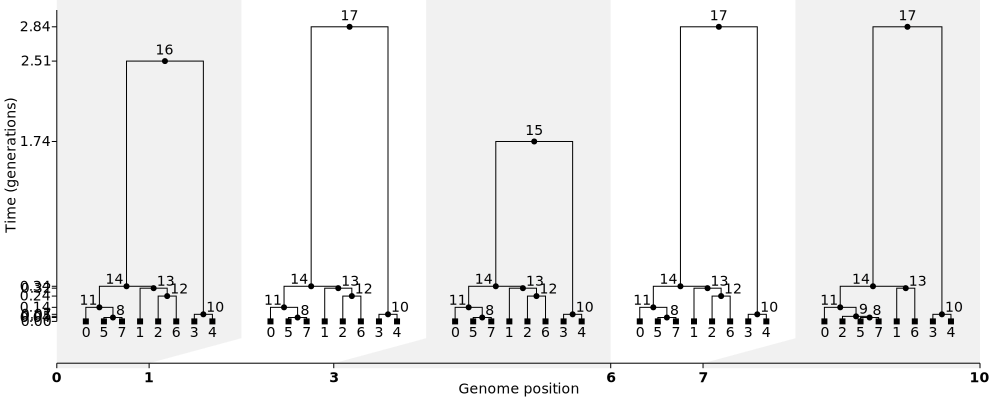

In [3]:
ts.draw_svg(y_axis=True, size=(1000,400))

In [6]:
from itertools import groupby
def print_mrcas(mrcas):
    """print MRCAs in a format that's easy to verify by eye"""
    [list(v) for k, v in groupby(sorted(mrcas.items(), key=lambda p: p[1]), key=lambda p: p[1])]

In [7]:
## TODO: Get rid of sorting in indexing!!

# For now, we take the mean of all pairs, but I think the end game solution is to
# progressively update the sum of the products between two trees.

# I'm not sure if we can actually remove the sorting here... in the next iteration of this code
# I plan on formulating the sampling differently, so maybe it'll be a moot point.

def compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu):
    E_ijij = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, j]))] for i, j in ij]) 
    E_ijik = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, k]))] for i, j, k in ijk])
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    D2 = E_ijij - 2 * E_ijik + E_ijkl
    return D2 * (mu ** 2)  # TODO: divide by prod of tree heights

def compute_pi2(left_tmrca, right_tmrca, ijkl, mu):
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    return E_ijkl * (mu ** 2)  # TODO: divide by prod of tree heights

def compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu):
    E_ijik = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, k]))] for i, j, k in ijk])
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    return 4 * (E_ijik - E_ijkl) * (mu ** 2)  # TODO: divide by prod of tree heights

In [8]:
from IPython import display
def iter_tree_tmrca(ts):
    # initialize the TMRCAs dict, which maps pairs of samples to their TMRCA
    tmrcas = {(i, j): tskit.NULL for i, j in combinations(range(ts.num_samples), 2)}
    # this is a set currently, which is slightly annoying because it's unordered (see all of the subsequent sorting gymnastics)
    samples_under_nodes = [set() for _ in range(ts.num_nodes)]
    # this list is needed for propagating changes back up the tree
    parents = [tskit.NULL] * ts.num_nodes

    # initialize the sample nodes with its corresponding sample
    for s in ts.samples():
        samples_under_nodes[s].add(s)

    # useful aliases
    edges_out = ts.indexes_edge_removal_order
    edges_in = ts.indexes_edge_insertion_order

    # Initialize our indices. tj, tk are the current edge in/edge out indices, respectively
    # t_left is the left genomic bound of the current valid tree
    tj, tk, t_left, tree_index = 0, 0, 0, 0

    # while there are edges_in left to consider or we're within the tree sequence length
    while tj < ts.num_edges or t_left < ts.sequence_length:
        # print(f"tree {tree_index} ============================")
        # while there are edges_out left to consider or we're within the current tree genomic coordinates
        while tk < ts.num_edges and ts.edges_right[edges_out[tk]] == t_left:
            # get the next edge to remove
            e = edges_out[tk]
            tk += 1
            # select the edge's parent/child node
            child = ts.edges_child[e]
            parent = ts.edges_parent[e]
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.t{tree_index - 1} .a{parent}.n{child} > .edge {{stroke: red; stroke-width: 2px}}'))
            while parent != tskit.NULL:
                # TODO: not sure if we need to clear out the tmrca table for removals (missing data)
                # remove samples from the parent node
                samples_under_nodes[parent] -= samples_under_nodes[child]
                # propagate the removal upward, removing samples from parents of parents and so on
                parent = parents[parent]
            # the current child now has no parents
            parents[child] = tskit.NULL

        while tj < ts.num_edges and ts.edges_left[edges_in[tj]] == t_left:
            # get the next edge to add
            e = edges_in[tj]
            tj += 1
            # select the edge's parent/child node
            child = ts.edges_child[e]
            parent = ts.edges_parent[e]
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.t{tree_index} .a{parent}.n{child} > .edge {{stroke: cyan; stroke-width: 2px}}'))
            # make the connection between the parent and child (needed later for upward propagation)
            parents[child] = parent
            # record the TMRCA between the parents and children, no need to propagate upwards (trouble will ensue)
            for i in sorted(samples_under_nodes[parent]):
                for j in sorted(samples_under_nodes[child]):
                    # print(tuple(sorted([i, j])), parent)
                    # tmrcas[tuple(sorted([i, j]))] = parent  # uncomment and comment the below line if you want mrcas 
                    tmrcas[tuple(sorted([i, j]))] = ts.nodes_time[parent]
            while parent != tskit.NULL:
                # add samples to the parent node
                samples_under_nodes[parent] |= samples_under_nodes[child]
                # propagate the addition upward, adding samples to parents of parents and so on
                parent = parents[parent]

        # begin by setting the righthand genomic coordinate as the sequence length
        t_right = ts.sequence_length
        # if there are more edges to consider, find the righthand bound
        if tj < ts.num_edges:
            t_right = min(t_right, ts.edges_left[edges_in[tj]])
        if tk < ts.num_edges:
            t_right = min(t_right, ts.edges_right[edges_out[tk]])

        yield tmrcas.copy()

        # set the lefthand bound
        t_left = t_right
        tree_index += 1

In [9]:
def combine(num_samples):
    """
    All sample pairings for 2/3/4 distinct samples.
    """
    ij = list(combinations(range(num_samples), 2))
    ijk = [(i, j, k) for i, j, k in product(range(num_samples), repeat=3)
           if i != k and i != j and j != k]
    ijkl = [(i, j, k, l) for i, j in combinations(range(num_samples), 2)
            for k in range(num_samples)
            for l in range(k + 1, num_samples)
            if i != k and j != k and l != i and l != j]
    return ij, ijk, ijkl

In [10]:
def compute_three_stats(ts, mu):
    """
    Build matricies for each statistic (# trees x # trees)
    """
    ij, ijk, ijkl = combine(ts.num_samples)
    D2 = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    Dz = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    pi2 = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    for (i, left_tmrca), (j, right_tmrca) in combinations_with_replacement(enumerate(iter_tree_tmrca(ts)), 2):
        D2[i, j] = compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu)
        Dz[i, j] = compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu)
        pi2[i, j] = compute_pi2(left_tmrca, right_tmrca, ijkl, mu)

    # after computing upper triangle, reflect downward
    tri_idx = np.tril_indices(ts.num_trees, k=-1)
    D2[tri_idx] = D2.T[tri_idx]
    Dz[tri_idx] = Dz.T[tri_idx]
    pi2[tri_idx] = pi2.T[tri_idx]
    return D2, Dz, pi2

In [12]:
# compute_three_stats(ts, mu=2e-8)
compute_three_stats(ts, mu=1)

(array([[6.23333333, 2.4       ],
        [2.4       , 1.06666667]]),
 array([[-6.53333333,  0.13333333],
        [ 0.13333333,  5.6       ]]),
 array([[30.93333333, 30.53333333],
        [30.53333333, 30.13333333]]))

In [10]:
# Moments result: LDstats([[7.07964602e-09 1.88790560e-09 1.60943953e-07]], [0.0008], num_pops=1, pop_ids=None)
Ne = 10_000
mu = 2e-8
r = 5e-4

# TODO: this could use some work. Right now, we're generating a bunch of tree sequences that usually
#       have two trees, and then compute our stats between the two trees.
while True:
    tss = msprime.sim_ancestry(
        samples=2,
        population_size=Ne,
        recombination_rate=r,
        sequence_length=2,
        num_replicates=1_000_000,
        # num_replicates=100_000,
    )
    stats = []
    for ts in tss:
        if ts.num_trees != 2:
            continue
        ij, ijk, ijkl = combine(ts.num_samples)
        tmrca_iter = iter_tree_tmrca(ts)
        left_tmrca = next(tmrca_iter)
        right_tmrca = next(tmrca_iter)
        stats.append([
            compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu),
            compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu),
            compute_pi2(left_tmrca, right_tmrca, ijkl, mu),
        ])
    print(np.mean(stats, 0))

[6.97925870e-09 1.96471692e-09 1.61045273e-07]
[7.13653127e-09 1.67404608e-09 1.60879484e-07]
[6.98943362e-09 2.03670357e-09 1.60841530e-07]
[7.12834574e-09 2.27112228e-09 1.60872443e-07]


KeyboardInterrupt: 